In [2]:
import numpy as np
import numpy.random as rng
import torch 
from torch.utils.data import TensorDataset, DataLoader
from copy import deepcopy 
from model import MLP_variant
from simulators import Generator_doubleNormal_lr
from simulators import Generator_doubleNormal
import matplotlib.pyplot as plt 
import time 
from scipy.stats import norm
from scipy.optimize import fsolve
from tqdm import tqdm  
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
def predict(model, Y): 
    model.eval()
    with torch.no_grad():
        data = torch.from_numpy(Y).type(torch.float).to(device)
        pred = model(data)
    return pred.detach().cpu().numpy()

# Linear Regression

In [12]:
rho = 0
N = 50
p = 50
rng.seed(0)
Sigma = np.ones((p, p)) * rho
Sigma = Sigma + np.diag(np.ones(p) * (1-rho))
X = rng.multivariate_normal(np.zeros(p), Sigma, N)
X = X - np.mean(X, axis=0)
X = X * np.sqrt(N / np.sum(X**2, axis=0))
np.save("./data/X_rho09_N50_p50.npy", X)

In [152]:
X = np.load("./data/X_rho0_N50_p50.npy")

In [153]:
np.corrcoef(X.T)

array([[ 1.00000000e+00,  1.16848590e-01,  7.53222663e-02, ...,
         7.89811400e-02, -2.60731615e-01, -9.67736674e-02],
       [ 1.16848590e-01,  1.00000000e+00, -9.20273190e-02, ...,
        -2.18356056e-06,  1.52459708e-01, -3.21697322e-02],
       [ 7.53222663e-02, -9.20273190e-02,  1.00000000e+00, ...,
        -1.80870042e-01,  1.03536703e-01, -2.71513308e-01],
       ...,
       [ 7.89811400e-02, -2.18356056e-06, -1.80870042e-01, ...,
         1.00000000e+00, -2.40520543e-01, -9.23143624e-02],
       [-2.60731615e-01,  1.52459708e-01,  1.03536703e-01, ...,
        -2.40520543e-01,  1.00000000e+00,  1.48169801e-01],
       [-9.67736674e-02, -3.21697322e-02, -2.71513308e-01, ...,
        -9.23143624e-02,  1.48169801e-01,  1.00000000e+00]])

In [3]:
X = np.load("./results/linear regression/X_p200_q975_exp0.npy")
X

array([[ 0.11096124, -1.20658915,  1.38876269, ..., -0.45960709,
         1.27803992, -0.6989734 ],
       [ 1.717001  ,  0.49574854, -0.0927022 , ..., -0.04049755,
         1.19841457, -2.01410873],
       [-0.21892588,  0.21185206,  1.88542418, ..., -0.1903413 ,
         0.96657823,  1.15744877],
       ...,
       [ 0.79000073,  1.21013674,  0.34427403, ...,  1.03806171,
        -1.07070599,  0.94925301],
       [ 0.01806298,  0.35198879,  0.92940414, ...,  0.39781412,
         0.16572629,  0.40858087],
       [ 0.66956391,  0.57823322,  1.72890534, ..., -0.63743735,
        -2.13014212, -0.89233741]])

In [154]:
md_q025 = MLP_variant(50, 50, [1024, 1024], 'leakyrelu').to(device)
md_q025.load_state_dict(torch.load("./model/linear regression/p50_q25_exp0.pt"))
md_q975 = MLP_variant(50, 50, [1024, 1024], 'leakyrelu').to(device)
md_q975.load_state_dict(torch.load("./model/linear regression/p50_q975_exp0.pt"))

<All keys matched successfully>

In [155]:
mean = np.load("./results/linear regression/mean_p50_q25_exp0.npy")
std = np.load("./results/linear regression/std_p50_q25_exp0.npy")

In [156]:
p = 50

In [157]:
theta = 0.05 
sigma0 = 0.1 
sigma1 = 5 
generator = Generator_doubleNormal_lr(X, theta, sigma0, sigma1)
rng.seed(1) 
gamma_test, beta_test, Y_test = generator.generate_samples(10000) 
Y_test_normalized = (Y_test - mean) / std 

In [158]:
np.save("./data/beta_test_p50_rho0.npy", beta_test)
np.save("./data/Y_test_p50_rho0.npy", Y_test)

In [159]:
pred_q025 = predict(md_q025, Y_test_normalized)
pred_q975 = predict(md_q975, Y_test_normalized)

Cross quantile

In [160]:
np.sum(pred_q025>pred_q975)/(p*10000)

2e-06

Cover rate

In [161]:
np.sum((pred_q025<=beta_test)&(beta_test<=pred_q975))/(p*10000)

0.949988

Mean CI width

In [162]:
np.mean(np.maximum(pred_q975-pred_q025, 0))

0.37556863

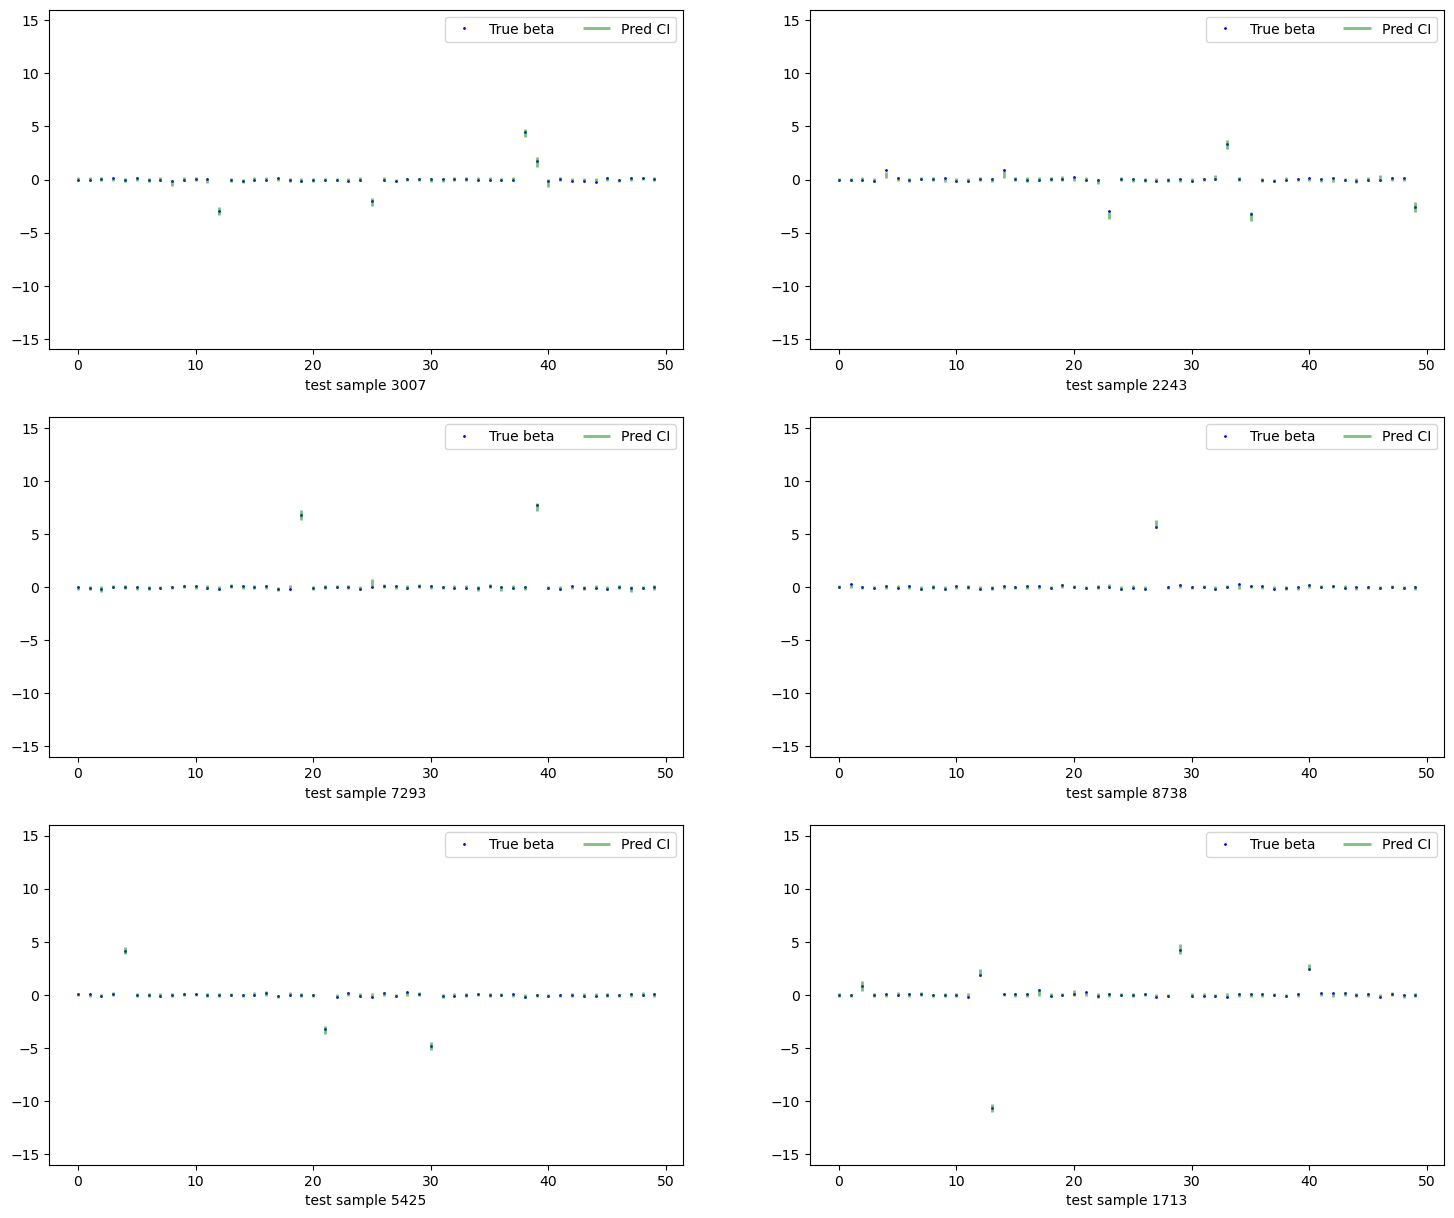

In [69]:
subset = np.where(np.abs(beta_test)>2)[0]
t = 1000 * time.time()
np.random.seed(int(t) % 2**32)
rng.shuffle(subset)
subset = subset[:6]    

plt.figure(figsize=(18,15))
for i, idx in enumerate(subset):
    plt.subplot(3,2,i+1)
    plt.plot(range(p), beta_test[idx], '.b', ms=2)
    plt.vlines(np.arange(p), pred_q025[idx], pred_q975[idx], color='green', alpha=0.5, lw=2)
    plt.legend(['True beta', 'Pred CI'], ncol=2)
    plt.ylim(-16,16)
    plt.xlabel(f'test sample {idx}')
plt.savefig('C:/Users/97255/OneDrive/Desktop/Bayesian Inference using DL/LM_exp0_figures/test_10.png')
plt.show()

In [192]:
test_id = 9
ssvs_CI = np.load(f"./data/ssvs_rho0_test{test_id}.npy")
bbssl_CI = np.load(f"./data/bbssl_rho0_test{test_id}.npy")
dblasso_CI = np.load(f"./data/dblasso_rho0_test{test_id}.npy")

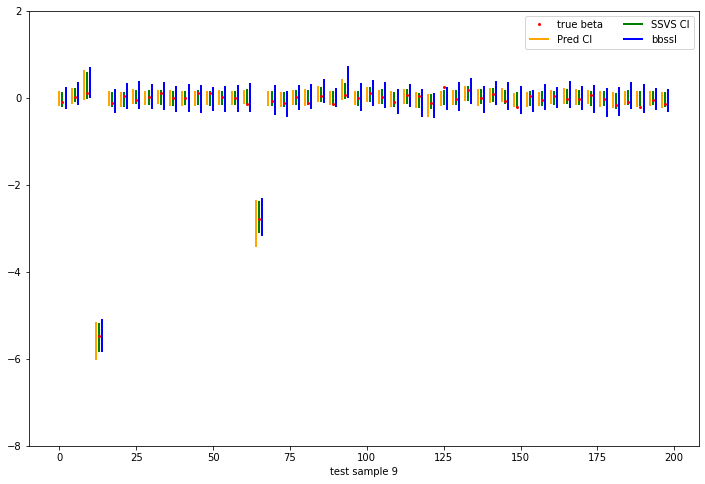

In [194]:
plt.figure(figsize=(12, 8))
plt.vlines(np.arange(p)*4, pred_q025[test_id], pred_q975[test_id], color='orange', alpha=1, lw=2)
plt.vlines(np.arange(p)*4+1, ssvs_CI[:,0], ssvs_CI[:,1], color='green', alpha=1, lw=2)
plt.vlines(np.arange(p)*4+2, bbssl_CI[:,0], bbssl_CI[:,1], color='blue', alpha=1, lw=2)
plt.plot(np.arange(p)*4+1, beta_test[test_id], '.r', ms=4)
plt.legend(["true beta", 'Pred CI', 'SSVS CI', 'bbssl'], ncol=2)
plt.ylim(-8, 2)
plt.xlabel(f'test sample {test_id}')
plt.savefig(f"C:/Users/Alienware/OneDrive/Desktop/Bayesian Inference using DL/vs_rho0_figures/test{test_id}")
plt.show()

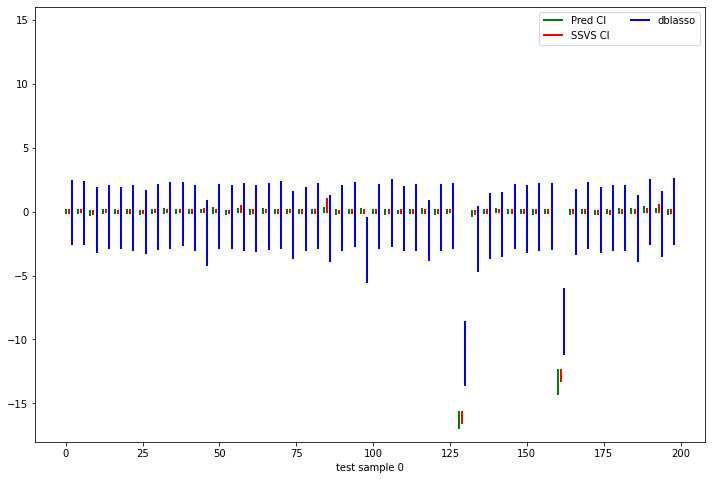

In [52]:
# plt.plot(range(p), beta_test[0], '.b', ms=2)
plt.figure(figsize=(12, 8))
plt.vlines(np.arange(p)*4, pred_q025[0], pred_q975[0], color='green', alpha=1, lw=2)
plt.vlines(np.arange(p)*4+1, ssvs_CI[:,0], ssvs_CI[:,1], color='red', alpha=1, lw=2)
plt.vlines(np.arange(p)*4+2, dblasso_CI[:,0], dblasso_CI[:,1], color='blue', alpha=1, lw=2)
plt.legend(['Pred CI', 'SSVS CI', 'dblasso'], ncol=2)
plt.ylim(-18,16)
plt.xlabel(f'test sample {0}')
plt.show()

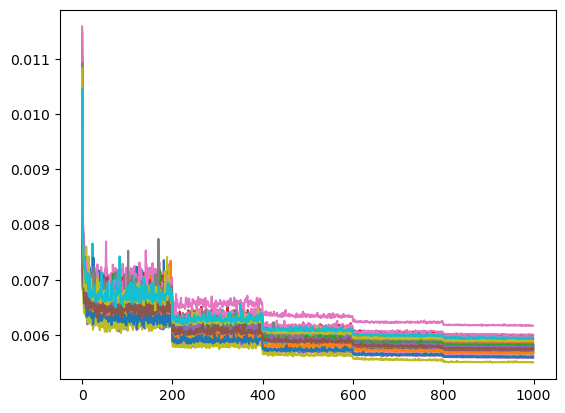

In [4]:
coordinate_loss = np.load("./results/linear regression/coordinate_loss_p50_q25_exp0.npy") 
plt.plot(coordinate_loss)
plt.show()

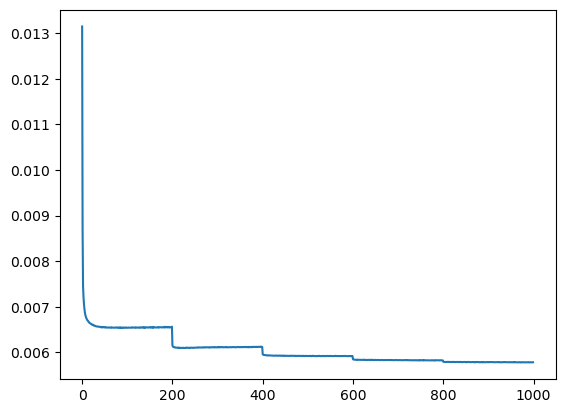

In [5]:
train_loss = np.load("./results/linear regression/train_losses_p50_q25_exp0.npy")
plt.plot(train_loss)
plt.show()

In [28]:
rho = 0
N = 50
p = 50
rng.seed(0)
Sigma = np.ones((p, p)) * rho
Sigma = Sigma + np.diag(np.ones(p) * (1-rho))
X = rng.multivariate_normal(np.zeros(p), Sigma, N)
X = X - np.mean(X, axis=0)
X = X * np.sqrt(N / np.sum(X**2, axis=0))
np.save("./data/X_rho0_N50_p50.npy", X)

# p=50

In [3]:
train_losses = np.load('./results/linear regression/train_losses_p200_q25_exp0.npy')
val_losses = np.load('./results/linear regression/val_losses_p200_q25_exp0.npy')

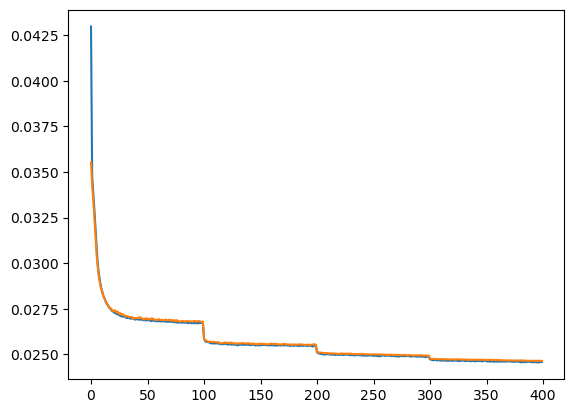

In [4]:
plt.plot(train_losses)
plt.plot(val_losses)
plt.show()

In [31]:
coordinate_loss = np.load("./results/linear regression/coordinate_loss_p200_q975_exp0.npy")

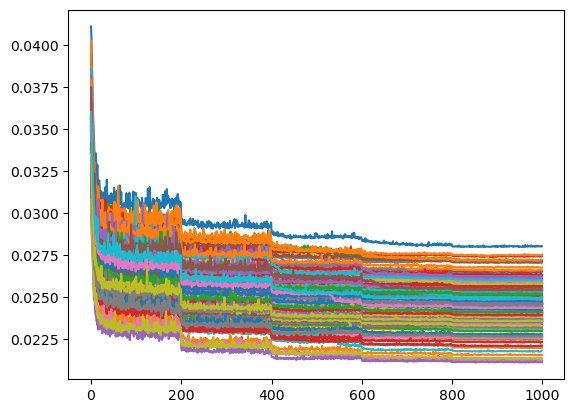

In [32]:
plt.plot(coordinate_loss)
plt.show()

In [13]:
mean = np.load("./results/mean_p50_q25_exp0.npy")
mean

array([-7.42424029e-03,  1.46540197e-03, -5.91988637e-03,  4.01072469e-03,
       -2.60670211e-03,  4.02615275e-03, -2.33799208e-03, -2.70410512e-03,
        1.22274609e-03, -1.67638261e-04, -7.72858166e-03,  5.25871144e-03,
       -4.41981630e-03,  1.02236721e-02,  5.75117707e-03, -1.80187393e-03,
       -4.27699624e-03,  2.12520993e-03, -6.11060328e-05, -8.26604612e-03,
       -3.41977553e-03,  3.28847613e-03,  2.71797040e-03, -4.26727379e-03,
        2.63348690e-03, -5.31144429e-03,  1.73750422e-03,  1.76159187e-03,
        6.15934304e-03, -2.33444195e-03, -5.09442507e-04,  7.91113053e-03,
        6.86524348e-03,  9.32738213e-04,  3.45273505e-03,  2.31579611e-03,
       -3.89607296e-03, -3.55956237e-03,  4.63078696e-03,  4.40170920e-03,
       -3.06914205e-03, -1.79889224e-03,  1.52153957e-03,  4.26476230e-03,
       -6.49922051e-03,  2.33434078e-03,  6.00017700e-03, -1.16134494e-04,
       -1.67950071e-03, -1.79748644e-03])

In [14]:
mean = np.load("./results/mean_p50_q975_exp0.npy")
mean

array([-7.42424029e-03,  1.46540197e-03, -5.91988637e-03,  4.01072469e-03,
       -2.60670211e-03,  4.02615275e-03, -2.33799208e-03, -2.70410512e-03,
        1.22274609e-03, -1.67638261e-04, -7.72858166e-03,  5.25871144e-03,
       -4.41981630e-03,  1.02236721e-02,  5.75117707e-03, -1.80187393e-03,
       -4.27699624e-03,  2.12520993e-03, -6.11060328e-05, -8.26604612e-03,
       -3.41977553e-03,  3.28847613e-03,  2.71797040e-03, -4.26727379e-03,
        2.63348690e-03, -5.31144429e-03,  1.73750422e-03,  1.76159187e-03,
        6.15934304e-03, -2.33444195e-03, -5.09442507e-04,  7.91113053e-03,
        6.86524348e-03,  9.32738213e-04,  3.45273505e-03,  2.31579611e-03,
       -3.89607296e-03, -3.55956237e-03,  4.63078696e-03,  4.40170920e-03,
       -3.06914205e-03, -1.79889224e-03,  1.52153957e-03,  4.26476230e-03,
       -6.49922051e-03,  2.33434078e-03,  6.00017700e-03, -1.16134494e-04,
       -1.67950071e-03, -1.79748644e-03])

In [15]:
std = np.load("./results/std_p50_q25_exp0.npy")

In [17]:
md_q025 = MLP_variant(50, 50, [1024, 1024], 'leakyrelu').to(device)
md_q975 = MLP_variant(50, 50, [1024, 1024], 'leakyrelu').to(device)
md_q025.load_state_dict(torch.load("./model/p50_q25_exp0.pt"))
md_q975.load_state_dict(torch.load("./model/p50_q975_exp0.pt"))

<All keys matched successfully>

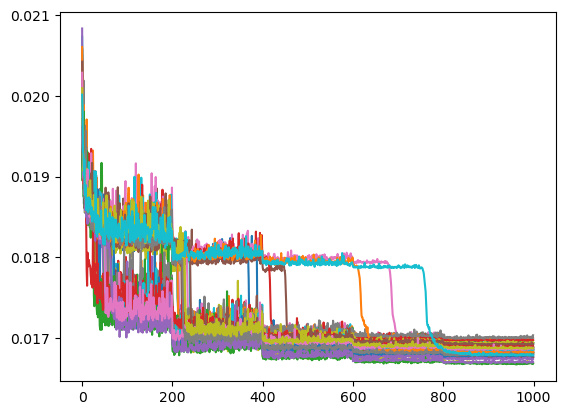

In [18]:
coordinate_loss_q025 = np.load("./results/coordinate_loss_p50_q25_exp0.npy")
plt.plot(coordinate_loss_q025)
plt.show()

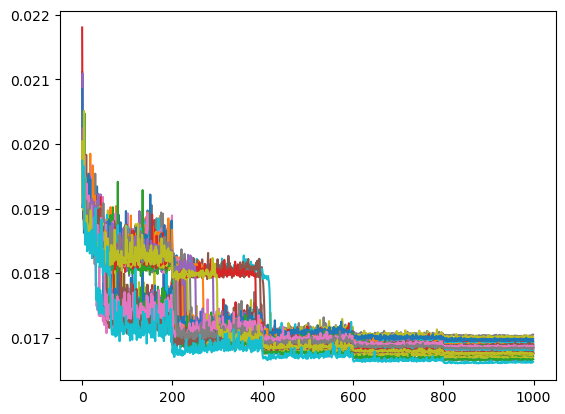

In [2]:
coordinate_loss_q975 = np.load("./results/coordinate_loss_p50_q975_exp0.npy")
plt.plot(coordinate_loss_q975)
plt.show()

In [20]:
from simulators import Generator_doubleNormal
theta = 0.05
sigma0 = 0.1
sigma1 = 5
sigma = 1
lr = 0.001 # learning rate
p = 50
generator = Generator_doubleNormal(p, theta, sigma0, sigma1)
rng.seed(1)
gamma_test, beta_test, Y_test = generator.generate_samples(1000000)
Y_test_normalized = (Y_test - mean) / std

In [21]:
true_q025 = np.load('./data/gs_q025.npy') 
true_q975 = np.load('./data/gs_q975.npy')
true_mean = np.load('./data/gs_mean.npy')

In [23]:
pred_q025 = predict(md_q025, Y_test_normalized)
q025_loss = np.mean(np.maximum(0.025*(beta_test-pred_q025),0.975*(pred_q025-beta_test)), 0)
q025_loss

array([0.01692049, 0.01688972, 0.01689267, 0.01685042, 0.01681917,
       0.01699558, 0.0169211 , 0.01693691, 0.01684633, 0.01694297,
       0.01688781, 0.01671864, 0.01686128, 0.01674839, 0.01696932,
       0.01688567, 0.0169423 , 0.01690773, 0.01676829, 0.01690717,
       0.01685491, 0.01672541, 0.01693134, 0.01682032, 0.01688154,
       0.01687759, 0.01689543, 0.01687232, 0.0168253 , 0.01678513,
       0.01692947, 0.01688183, 0.01690142, 0.01693085, 0.01696865,
       0.01688599, 0.01682538, 0.01686619, 0.01693351, 0.01672398,
       0.01681419, 0.01701237, 0.01695429, 0.01679002, 0.01684752,
       0.01688275, 0.01691334, 0.01700171, 0.01686405, 0.01684737])

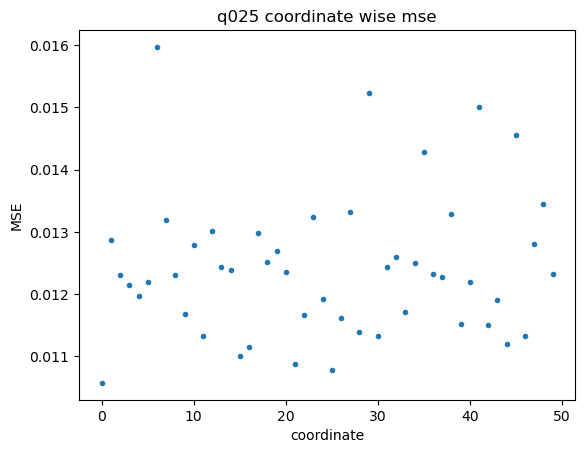

In [24]:
mse_q025 = np.mean((true_q025 - pred_q025[:10000,:])**2, 0)
plt.plot(mse_q025,'.')
plt.xlabel('coordinate')
plt.ylabel('MSE')
plt.title('q025 coordinate wise mse')
plt.show()

In [25]:
np.mean(mse_q025)

0.012408436827626717

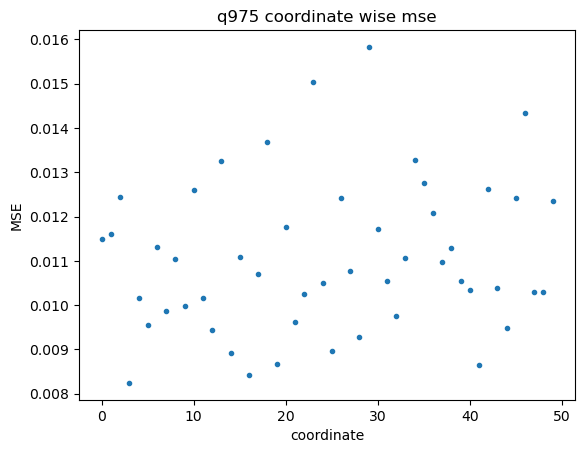

In [26]:
pred_q975 = predict(md_q975, Y_test_normalized)
mse_q975 = np.mean((true_q975 - pred_q975[:10000,:])**2, 0)
plt.plot(mse_q975,'.')
plt.xlabel('coordinate')
plt.ylabel('MSE')
plt.title('q975 coordinate wise mse')
plt.show()

In [27]:
np.mean(mse_q975)

0.011045360812373615

In [28]:
md_mean = MLP_variant(p, p, [1024, 1024], 'leakyrelu').to(device)
md_mean.load_state_dict(torch.load('./model/p50_mean_week10.pt'))
pred_mean = predict(md_mean, Y_test_normalized)

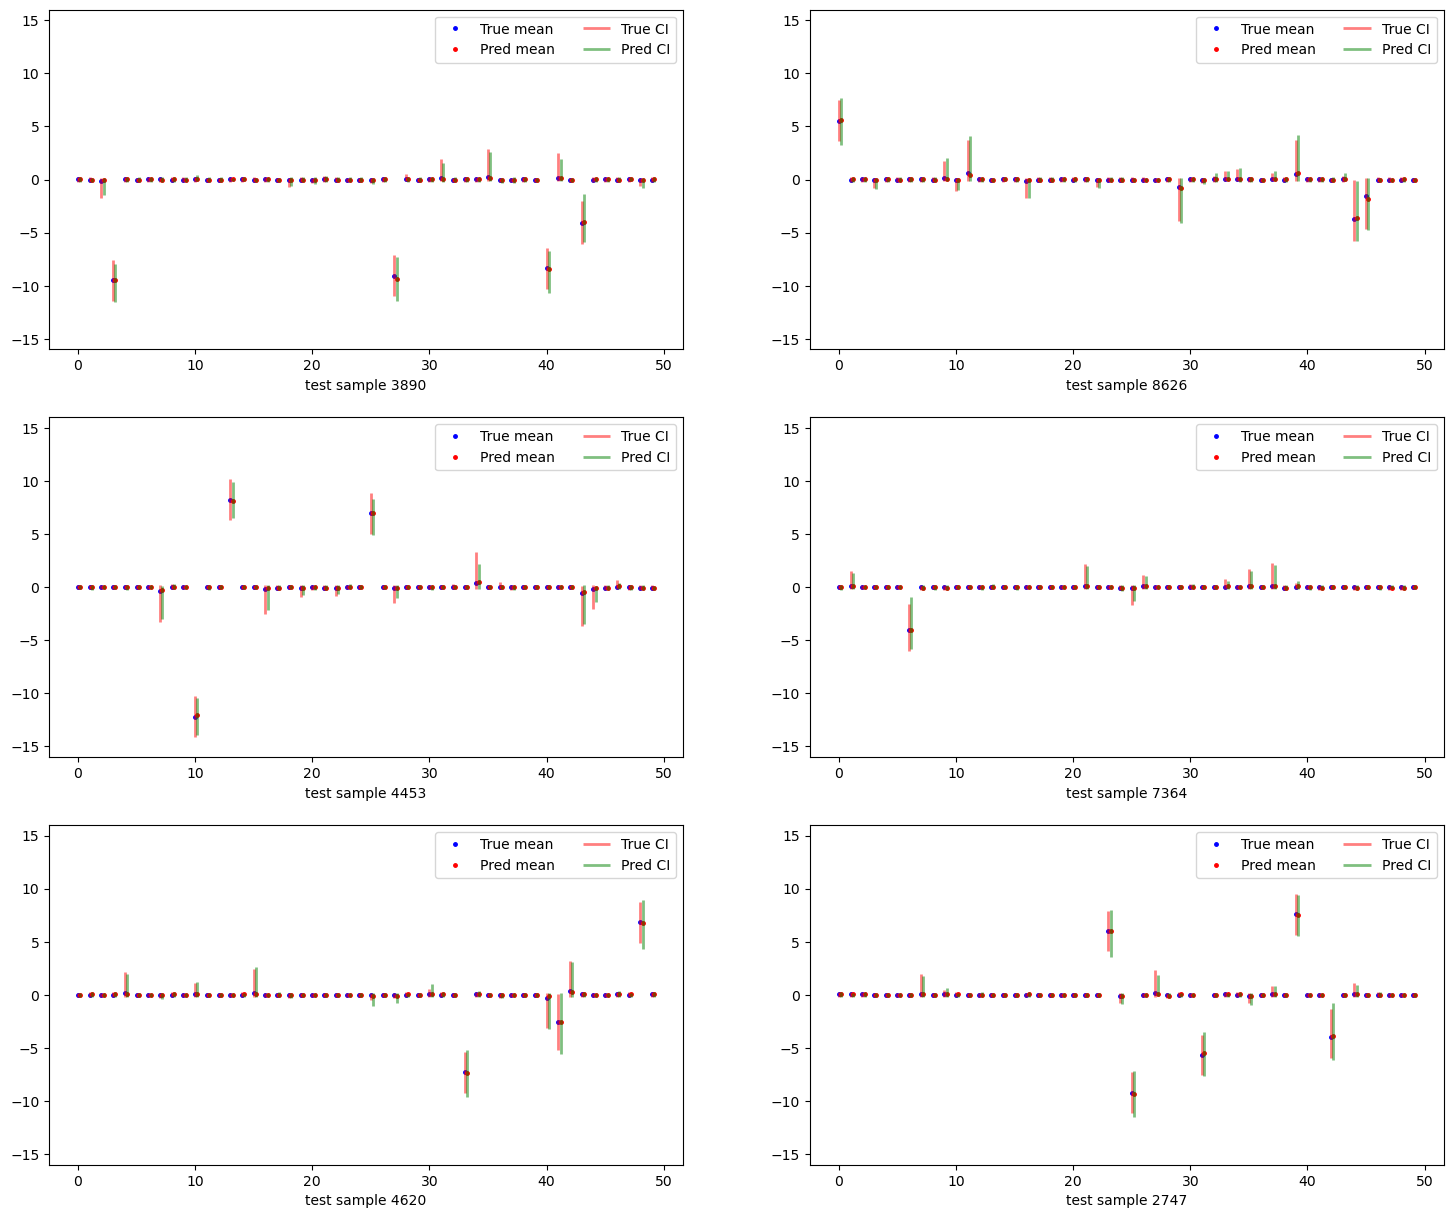

In [31]:
subset = np.where(np.abs(beta_test[:10000,:])>2)[0]
t = 1000 * time.time()
np.random.seed(int(t) % 2**32)
rng.shuffle(subset)
subset = subset[:6]    

plt.figure(figsize=(18,15))
for i, idx in enumerate(subset):
    plt.subplot(3,2,i+1)
    plt.plot(range(p), true_mean[idx], '.b', ms=5)
    plt.plot(np.arange(p)+0.2, pred_mean[idx], '.r', ms=5)
    plt.vlines(np.arange(p), true_q025[idx], true_q975[idx], color='red', alpha=0.5, lw=2)
    plt.vlines(np.arange(p)+0.2, pred_q025[idx], pred_q975[idx], color='green', alpha=0.5, lw=2)
    plt.legend(['True mean', 'Pred mean', 'True CI', 'Pred CI'], ncol=2)
    plt.ylim(-16,16)
    plt.xlabel(f'test sample {idx}')
# plt.savefig('C:/Users/97255/OneDrive/Desktop/Bayesian Inference using DL/s2048_test_figures/test_10.png')
plt.show()

# p=200

In [14]:
train_losses_q025 = np.load('./results/train_losses_p200_q25_exp2.npy')
val_losses_q025 = np.load('./results/val_losses_p200_q25_exp2.npy')  
coordinate_loss_q025 = np.load('./results/coordinate_loss_p200_q25_exp2.npy')
train_losses_q975 = np.load('./results/train_losses_p200_q975_exp2.npy')
val_losses_q975 = np.load('./results/val_losses_p200_q975_exp2.npy')  
coordinate_loss_q975 = np.load('./results/coordinate_loss_p200_q975_exp2.npy')

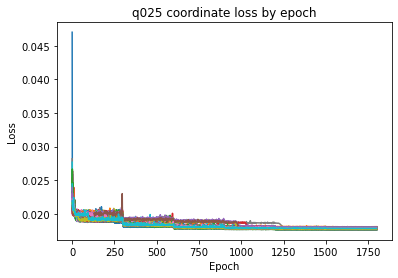

In [16]:
plt.plot(coordinate_loss_q025)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("q025 coordinate loss by epoch")
plt.show()

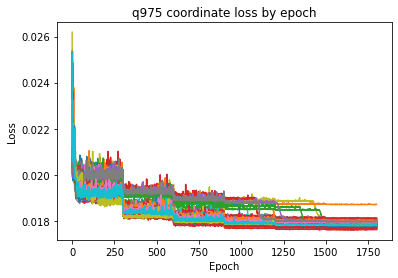

In [17]:
plt.plot(coordinate_loss_q975)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("q975 coordinate loss by epoch")
plt.show()

In [9]:
p = 200
theta = 0.05
sigma0 = 0.1
sigma1 = 5
sigma = 1
generator = Generator_doubleNormal(p, theta, sigma0, sigma1)
rng.seed(1)
gamma_test, beta_test, Y_test = generator.generate_samples(5000)

In [13]:
'''
The posterior is also a Gaussian mixture of two components. The posterior mean is easy to compute. However, the 
quantile doesn't have close form solution. Use fsolve in scipy.optimize to solve equations for quantile.
'''
def computeNormalStats(sigma, sigma0, sigma1, Y):
    tau = 1 / sigma**2
    tau0 = 1 / sigma0**2
    tau1 = 1 / sigma1**2
    tau0_ = tau0 + tau 
    tau1_ = tau1 + tau 
    theta_ = theta / (theta + (1-theta) * np.sqrt(tau1_*tau0/(tau0_*tau1)) \
        * np.exp(-0.5 * tau**2 * (tau0_-tau1_) / (tau0_*tau1_) * Y**2))
    mu1 = tau / tau1_ * Y 
    mu0 = tau / tau0_ * Y 
    true_mean = theta_ * mu1 + (1-theta_) * mu0
    # Use different initial values according to Y to avoid solver failure.
    if np.abs(Y) > 4:
        q025 = fsolve(lambda x: theta_ * norm.cdf(x, mu1, (1/tau1_)**0.5) + (1-theta_) * norm.cdf(x, mu0, (1/tau0_)**0.5) - 0.025, Y)
        q975 = fsolve(lambda x: theta_ * norm.cdf(x, mu1, (1/tau1_)**0.5) + (1-theta_) * norm.cdf(x, mu0, (1/tau0_)**0.5) - 0.975, Y)
    else:
        q025 = fsolve(lambda x: theta_ * norm.cdf(x, mu1, (1/tau1_)**0.5) + (1-theta_) * norm.cdf(x, mu0, (1/tau0_)**0.5) - 0.025, 0)
        q975 = fsolve(lambda x: theta_ * norm.cdf(x, mu1, (1/tau1_)**0.5) + (1-theta_) * norm.cdf(x, mu0, (1/tau0_)**0.5) - 0.975, 0)        
    return true_mean, q025, q975

In [15]:
'''
Only the first 10,000 test samples are used for comparison. 
'''
true_mean = np.zeros((5000, p))
true_q025 = np.zeros((5000, p))
true_q975 = np.zeros((5000, p))

for i in tqdm(range(5000)):
    for j in range(p):
        true_mean[i,j], true_q025[i,j], true_q975[i,j] = computeNormalStats(sigma, sigma0, sigma1, Y_test[i,j])

100%|██████████| 5000/5000 [30:06<00:00,  2.77it/s]


In [16]:
np.save("./data/gs_p200_q025", true_q025)
np.save("./data/gs_p200_q975", true_q975)
np.save("./data/gs_p200_mean", true_mean)

In [7]:
true_q025 = np.load("./data/gs_p200_q025.npy")
true_q975 = np.load("./data/gs_p200_q975.npy")

In [8]:
mean = np.load("./results/mean_p200_q25_exp2.npy")
std = np.load("./results/std_p200_q25_exp2.npy")

In [10]:
Y_test_normalized = (Y_test - mean) / std 

In [20]:
def predict(model, Y):
    model.eval()
    with torch.no_grad():
        data = torch.from_numpy(Y).type(torch.float).to(device)
        pred = model(data)
    return pred.detach().cpu().numpy()

In [11]:
md_q025 = MLP_variant(p, p, [1024, 1024], 'leakyrelu').to(device) 
md_q025.load_state_dict(torch.load("./model/p200_q25_exp2.pt"))

<All keys matched successfully>

In [12]:
pred_q025 = predict(md_q025, Y_test_normalized)
q025_loss = np.mean(np.maximum(0.025*(beta_test-pred_q025),0.975*(pred_q025-beta_test)), 0)
q025_loss

array([0.01857996, 0.01768403, 0.01580519, 0.01982868, 0.01777662,
       0.01954855, 0.01769662, 0.0175347 , 0.01759245, 0.01836035,
       0.01891978, 0.01877827, 0.01667976, 0.01739838, 0.0186043 ,
       0.01849827, 0.01788731, 0.01616683, 0.01855478, 0.01778649,
       0.01980343, 0.01758451, 0.01728855, 0.016072  , 0.01862428,
       0.0178464 , 0.01887133, 0.01850738, 0.01772144, 0.01832583,
       0.01694161, 0.01728571, 0.01871582, 0.01622316, 0.01937885,
       0.01764392, 0.01867782, 0.02057979, 0.02125011, 0.01781129,
       0.01516343, 0.01787412, 0.01528551, 0.01816258, 0.01740298,
       0.0191405 , 0.02016382, 0.01507418, 0.0185668 , 0.01603481,
       0.01779862, 0.01733538, 0.01624112, 0.02076756, 0.01655289,
       0.01823608, 0.01820046, 0.01480971, 0.01606845, 0.01993388,
       0.01789224, 0.01544909, 0.01633823, 0.01849523, 0.01664935,
       0.01858659, 0.01625849, 0.01870205, 0.0195127 , 0.01852624,
       0.01754352, 0.01800324, 0.01776381, 0.01972018, 0.01594

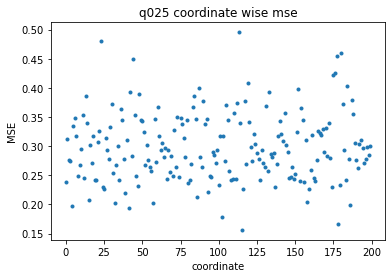

In [13]:
mse_q025 = np.mean((true_q025 - pred_q025)**2, 0)
plt.plot(mse_q025,'.')
plt.xlabel('coordinate')
plt.ylabel('MSE')
plt.title('q025 coordinate wise mse')
plt.show()